# Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  4. Task 4: Evaluating our Pipeline with Ragas
  5. Task 6: Making Adjustments and Re-Evaluating

But first! Let's set some dependencies!

## Dependencies and API Keys:

> NOTE: Please skip the pip install commands if you are running the notebook locally.

In [90]:
#!pip install -qU ragas==0.2.10

In [91]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

We'll also need to provide our API keys.

First, OpenAI's for our LLM/embedding model combination!

In [1]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

OPTIONALLY:

We can also provide a Ragas API key - which you can sign-up for [here](https://app.ragas.io/).

In [2]:
os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [3]:
!mkdir data

path = "C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data"

print(path)

C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data


In [4]:
!curl -k https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o "{path}/2023_llms.html"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 31427    0 31427    0     0   258k      0 --:--:-- --:--:-- --:--:--  266k


In [5]:
!curl -k https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o "{path}/2024_llms.html"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 70286    0 70286    0     0   563k      0 --:--:-- --:--:-- --:--:--  576k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [6]:
from langchain_community.document_loaders import DirectoryLoader

path = "C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()
print(docs)

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


[Document(metadata={'source': 'C:\\Users\\dabra\\OneDrive\\Documents\\AI Makerspace\\AIE5\\08_Evaluating_RAG_With_Ragas\\data\\2023_llms.html'}, page_content="Simon Willison’s Weblog\n\nSubscribe\n\nStuff we figured out about AI in 2023\n\n31st December 2023\n\n2023 was the breakthrough year for Large Language Models (LLMs). I think it’s OK to call these AI—they’re the latest and (currently) most interesting development in the academic field of Artificial Intelligence that dates back to the 1950s.\n\nHere’s my attempt to round up the highlights in one place!\n\nLarge Language Models\n\nThey’re actually quite easy to build\n\nYou can run LLMs on your own devices\n\nHobbyists can build their own fine-tuned models\n\nWe don’t yet know how to build GPT-4\n\nVibes Based Development\n\nLLMs are really smart, and also really, really dumb\n\nGullibility is the biggest unsolved problem\n\nCode may be the best application\n\nThe ethics of this space remain diabolically complex\n\nMy blog in 2023

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

c:\Users\dabra\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Generating Samples: 100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


In [9]:
print(dataset.to_pandas())

                                           user_input  \
0   What significant developments in Large Languag...   
1   how chatgpt work with prompts and why it somet...   
2   What significant insights about Large Language...   
3   What are the ethical considerations surroundin...   
4   How has the environmental impact of AI models ...   
5   How has the environmental impact of AI changed...   
6   How have inference-scaling reasoning models an...   
7   How has the environmental impact of AI models ...   
8   What advancements in GPT-4 were observed betwe...   
9   What are some of the challenges and advancemen...   
10  What advancements in GPT-4V and GPT-4 have bee...   
11  How does the Claude 3.5 Sonnet compare to othe...   

                                   reference_contexts  \
0   [Code may be the best application The ethics o...   
1   [Based Development As a computer scientist and...   
2   [Simon Willison’s Weblog Subscribe Stuff we fi...   
3   [easy to follow. The rest 

#### OPTIONAL:

If you've provided your Ragas API key - you can use this web interface to look at the created data!

In [10]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/ca6cf647-4dd9-48f1-8922-206ced6817cc


'https://app.ragas.io/dashboard/alignment/testset/ca6cf647-4dd9-48f1-8922-206ced6817cc'

## LangChain RAG

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [11]:
path = "C:/Users/dabra/OneDrive/Documents/AI Makerspace/AIE5/08_Evaluating_RAG_With_Ragas/data"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


In [12]:
docs

[Document(metadata={'source': 'C:\\Users\\dabra\\OneDrive\\Documents\\AI Makerspace\\AIE5\\08_Evaluating_RAG_With_Ragas\\data\\2023_llms.html'}, page_content="Simon Willison’s Weblog\n\nSubscribe\n\nStuff we figured out about AI in 2023\n\n31st December 2023\n\n2023 was the breakthrough year for Large Language Models (LLMs). I think it’s OK to call these AI—they’re the latest and (currently) most interesting development in the academic field of Artificial Intelligence that dates back to the 1950s.\n\nHere’s my attempt to round up the highlights in one place!\n\nLarge Language Models\n\nThey’re actually quite easy to build\n\nYou can run LLMs on your own devices\n\nHobbyists can build their own fine-tuned models\n\nWe don’t yet know how to build GPT-4\n\nVibes Based Development\n\nLLMs are really smart, and also really, really dumb\n\nGullibility is the biggest unsolved problem\n\nCode may be the best application\n\nThe ethics of this space remain diabolically complex\n\nMy blog in 2023

Now that we have our data loaded, let's split it into chunks!

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

74

#### ❓ Question: 

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`?

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> ANSWER:  </b> 

The `chunk_overlap` parameter indicates the number of characters overlapping between consecutive chunks. This means the first 200 characters of each chunk will contain the last 200 characters of the previous chunk.  This parameter is used to maintain context and retain information across the chunks.  

By preserving information between chunks, we can preserve semantic contexts, contextual relationships, and maintain coherence across sentences.  

While a larger overlap helps preserve the natural flow of information and reduces the risk of losing critical context at chunk boundaries, it also increases storage requirements, increases redundancy (leading to processing overheads when tasks use these chunks), and computational costs.

Like every other use case, it is critical to determine the correct value for each situation, input data, use case requirements, tech stack being used, and final application being built.

</span>
</div>

Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [14]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [15]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years",
    embedding=embeddings,
)

We can now add our documents to our vector store.

In [16]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [17]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Now we can produce a node for retrieval!

In [18]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Augmented

Let's create a simple RAG prompt!

In [19]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-mini` to avoid using the same model as our judge model.

In [20]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Then we can create a `generate` node!

In [21]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [22]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [23]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Let's do a test to make sure it's doing what we'd expect.

In [24]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [25]:
response["response"]

'LLM (Large Language Model) agents are useful in several ways:\n\n1. **Ease of Building**: They are relatively easy to construct, requiring only a few hundred lines of code, as long as you have access to sufficient quality and quantity of training data and the necessary computational resources. This democratizes the capability to create LLMs, not just limiting it to the wealthy.\n\n2. **Running on Personal Devices**: Recent releases have made it possible to run LLMs on personal computers, making the technology more accessible for individual use without the need for expensive servers.\n\n3. **Effective Code Generation**: LLMs excel at writing code, which is a significant application. The structured nature of programming languages allows LLMs to perform this task effectively, leading to increased productivity in software development.\n\n4. **Handling Hallucinations**: Although LLMs tend to hallucinate, especially in natural language output, this issue is less critical in code generation 

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [26]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [27]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [28]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

Next up - we simply evaluate on our desired metrics!

In [29]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating: 100%|██████████| 72/72 [08:38<00:00,  7.20s/it]


{'context_recall': 0.6756, 'faithfulness': 0.7567, 'factual_correctness': 0.4733, 'answer_relevancy': 0.9488, 'context_entity_recall': 0.4988, 'noise_sensitivity_relevant': 0.3251}

## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model (which was updated fairly [recently](https://docs.cohere.com/v2/changelog/rerank-v3.5)) - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

In [30]:
os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")


We'll first set our retriever to return more documents, which will allow us to take advantage of the reranking.

In [31]:
retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

In [ ]:
!pip install -qU cohere langchain_cohere

In [32]:
import sys
import subprocess

print(f"Using Python: {sys.executable}")
subprocess.check_call([sys.executable, "-m", "pip", "install", "langchain-cohere"])

Using Python: c:\Users\dabra\AppData\Local\Programs\Python\Python39\python.exe


0

In [33]:
import langchain_cohere
from langchain_cohere import CohereRerank

In [34]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

# def retrieve_adjusted(state):
#   compressor = CohereRerank(model="rerank-v3.5")
#   compression_retriever = ContextualCompressionRetriever(
#     base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
#   )
#   retrieved_docs = compression_retriever.invoke(state["question"])
#   return {"context" : retrieved_docs}

def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5", top_n = 5)
  compression_retriever = ContextualCompressionRetriever(
    # base_compressor=compressor, base_retriever=retriever, search_kwargs={"k": 5}
    base_compressor=compressor, base_retriever=retriever
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

We can simply rebuild our graph with the new retriever!

In [35]:
class State(TypedDict):
  question: str
  context: List[Document]
  response: str

graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

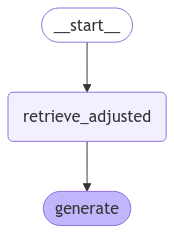

In [36]:
graph

In [37]:
response = graph.invoke({"question" : "How are LLM agents useful?"})
response["response"]

"LLM agents, while still an emerging concept, show potential utility primarily in the context of writing code. Their ability to generate code is enhanced by the simplicity of programming languages' grammar compared to natural languages, making LLMs surprisingly effective in that domain. They can generate code, run it, identify errors, and iterate on solutions autonomously, which mitigates some of the issues related to their tendency to hallucinate or produce inaccurate results.\n\nHowever, there are significant challenges and limitations associated with LLM agents, particularly regarding their reliability and discernment of truth. The context notes concerns about gullibility, where LLMs may accept false information without question, impacting their effectiveness in roles like travel agents or digital assistants. The perception of LLMs being useful is often clouded by skepticism regarding their flaws, including environmental impact, ethical concerns, and potential misinformation.\n\nOve

In [38]:
eval_ds_pandas = dataset.to_pandas()

print(eval_ds_pandas.columns)

eval_ds_pandas = eval_ds_pandas[['user_input', 'reference_contexts', 'reference', 'synthesizer_name']]

print(eval_ds_pandas.columns)

Index(['user_input', 'retrieved_contexts', 'reference_contexts', 'response',
       'reference', 'synthesizer_name'],
      dtype='object')
Index(['user_input', 'reference_contexts', 'reference', 'synthesizer_name'], dtype='object')


In [40]:
import time

evaluation_dataset_updated = EvaluationDataset.from_pandas(eval_ds_pandas)

for test_row in evaluation_dataset_updated:
    response = graph.invoke({"question": test_row.user_input})  # Adjusted
    test_row.response = response["response"]
    test_row.retrieved_contexts = [context.page_content for context in response["context"]]
    time.sleep(2)

# for test_row in evaluation_dataset_updated:
#   response = graph.invoke({"question" : test_row.eval_sample.user_input})
#   test_row.eval_sample.response = response["response"]
#   test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
#   time.sleep(2) # To try to avoid rate limiting.

In [41]:
result = evaluate(
    dataset=evaluation_dataset_updated,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating: 100%|██████████| 72/72 [07:36<00:00,  6.34s/it]


{'context_recall': 0.7809, 'faithfulness': 0.8526, 'factual_correctness': 0.5567, 'answer_relevancy': 0.9355, 'context_entity_recall': 0.4912, 'noise_sensitivity_relevant': 0.2896}

#### ❓ Question: 

Which system performed better, on what metrics, and why?

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> ANSWER:  </b> 

RAG System 1 uses a retriever extracting 5 documents (k = 5). RAG System 2 uses a retriever extracting 5 documents (k = 20) and uses Cohere's reranking model (applying contextual compression using CohereRerank to select and order top 20 most relevant documents, thereby, improving the quality of retrieved documents).  
The comparison of these 2 RAG pipelines (tabulating the performance results printed above) shows the classic trade-off between recall and noise in action.    


|                Metric            |                                                               Definition                                                           |     RAG System 1 (k=5) |     RAG System 2 (k=20) |        Higher is Better?   |     Which System is Better?    |
|:--------------------------------:|:----------------------------------------------------------------------------------------------------------------------------------:|:----------------------:|:-----------------------:|:--------------------------:|:------------------------------:|
|     Context Recall               |      Measures   # of relevant documents retrieved from the knowledge base                                                          |     0.6756             |     0.7809              |     ✅ Yes                  |     RAG System 2               |
|     Faithfulness                 |     Assesses whether the responses are grounded in   the retrieved documents                                                       |     0.7567             |     0.8526              |     ✅ Yes                  |     RAG System 1               |
|     Factual   Correctness        |     Evaluates if the response is factually accurate   based on external knowledge, even if not present in the retrieved documents. |     0.4733             |     0.5567              |     ✅ Yes                  |     RAG System 1               |
|     Answer   Relevancy           |     Measures how well the response addresses the   query - an indicator of contextual relevance                                    |     0.9488             |     0.9355              |     ✅ Yes                  |     RAG System 2               |
|     Context   Entity Recall      |     Measures how many key entities from the ground   truth context appear in the retrieved documents                               |     0.4988             |     0.4912              |     ✅ Yes                  |     RAG System 2               |
|     Noise   Sensitivity Relevant |     Measures the system’s sensitivity to noise /   irrelevant information                                                          |     0.3251             |     0.2896              |     ❌ No (Lower is Better) |     RAG System 1               |


Increasing k (more retrieved documents), as shown in RAG system 2 (k=20), improves recall but introduces more noise.
-  System 2 retrieves more relevant information (higher context recall, entity recall).  
-  But it struggles with faithfulness and factual correctness because it has to filter through more documents, increasing irrelevant or contradictory content.  

RAG System 1 (k=5) retrieves fewer but more relevant documents, leading to better factual correctness and faithfulness.  
-  Lower noise sensitivity means it is more robust to irrelevant data.  
-  More factually correct responses because it works with fewer, more precise sources.

Depending on the business objective and use case goals, we can choose either of the systems.  

1. If precision and factual correctness are more important (e.g., medical, legal domain), RAG System 1 (k=5) is better.  
2. If higher recall and broad knowledge retrieval are required (e.g., research, exploratory Q&A), RAG System 2 (k=20) is better.
</span>
</div>